# Importálás

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# Nlp library
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer

# sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import explained_variance_score

#Tenserflow Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

C:\Users\kvend\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Adatvizualizáció

In [2]:
jobs = pd.read_csv('fake_job_postings.csv')

In [3]:
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<AxesSubplot:ylabel='fraudulent'>

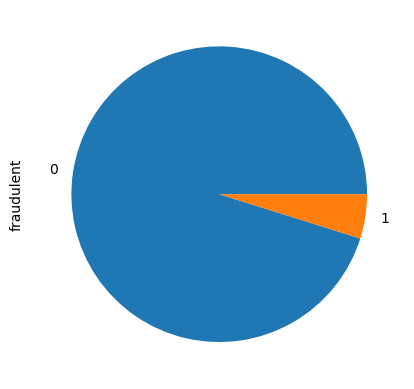

In [4]:
jobs.fraudulent.value_counts().plot(kind='pie')

In [5]:
print(jobs.fraudulent.value_counts()[0]/len(jobs))
print(jobs.fraudulent.value_counts()[0])
print(jobs.fraudulent.value_counts()[1])

0.9515659955257271
17014
866


In [6]:
def isNaN(string):
    return string != string

In [7]:
y0=[]
y1=[]
for c in jobs.columns:
    y0.append(len(jobs[c][isNaN(jobs[c])==1][jobs.fraudulent==0])/jobs.fraudulent.value_counts()[0])
    y1.append(len(jobs[c][isNaN(jobs[c])==1][jobs.fraudulent==1])/jobs.fraudulent.value_counts()[1])

Text(0.5, 1.0, 'NaN ratio')

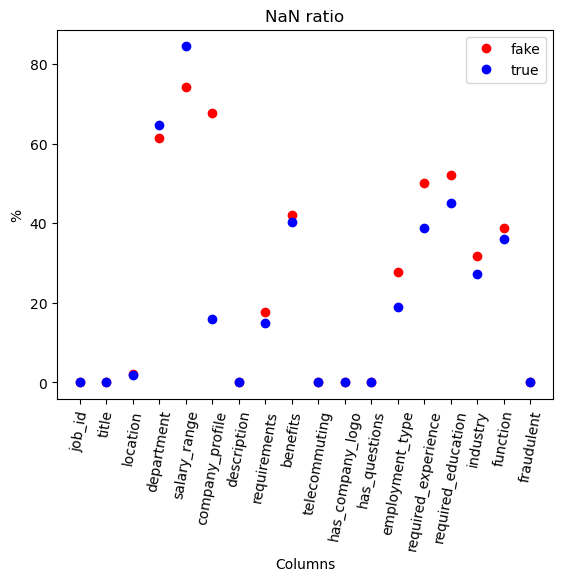

In [8]:
import matplotlib.pyplot as plt
x=jobs.columns
plt.plot(x,100*np.array(y1),'ro',x,100*np.array(y0),'bo')
plt.legend(["fake", "true"])
plt.ylabel('%')
plt.xlabel('Columns')
plt.xticks(rotation=80)
plt.title("NaN ratio")

In [9]:
jobs.title = jobs.title.str.strip()
title = jobs.title.value_counts()[:10]

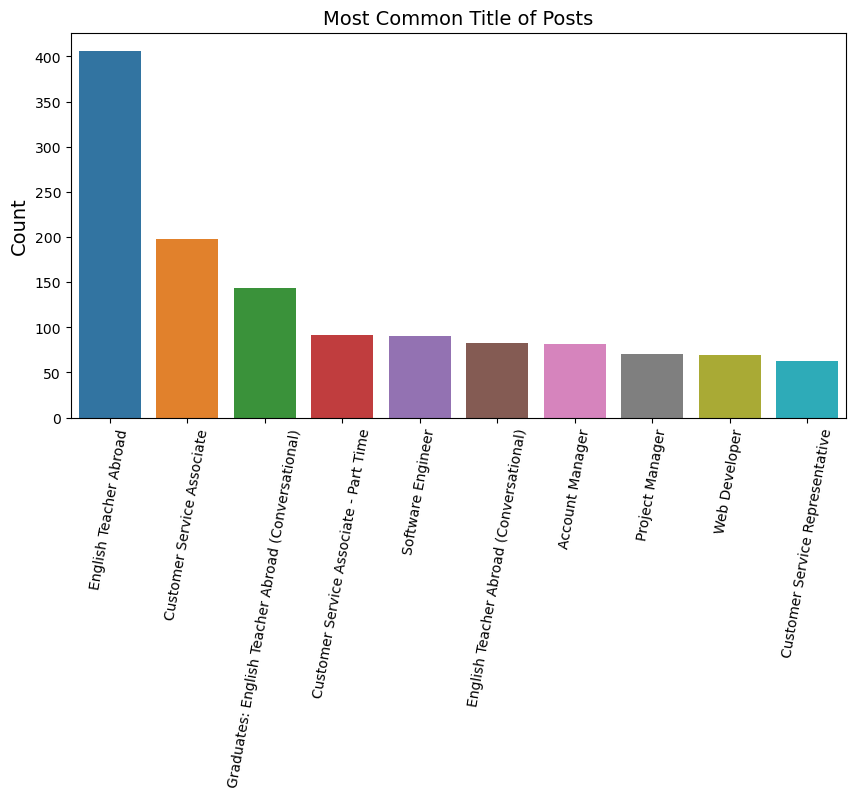

In [10]:
plt.figure(figsize = (10,5))
sb.barplot(x = title.index, y = title )
plt.title("Most Common Title of Posts", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=80);

In [11]:
location = jobs.location.value_counts()[:10]

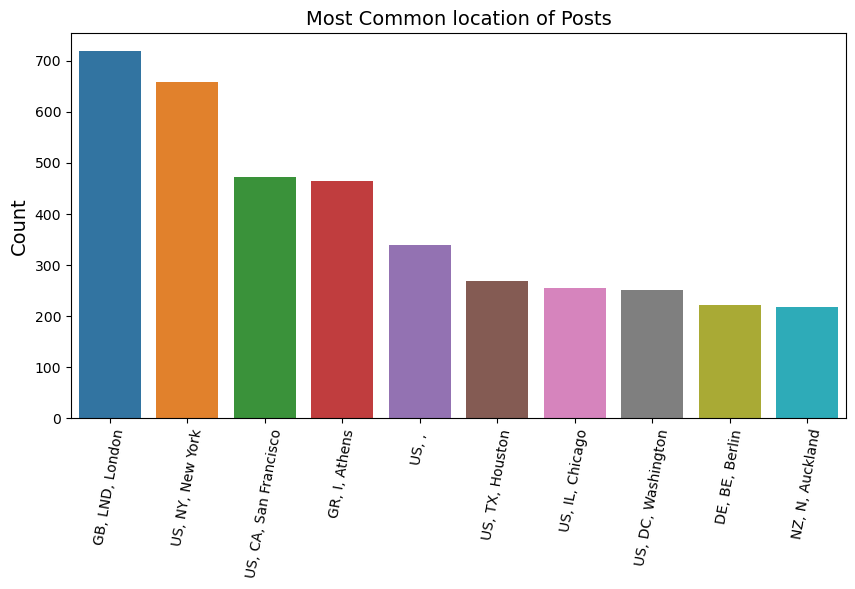

In [12]:
plt.figure(figsize = (10,5))
sb.barplot(x = location.index, y = location )
plt.title("Most Common location of Posts", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=80);

In [13]:
loc=jobs.location.value_counts(dropna=False)
loc1=jobs.location[jobs.fraudulent==1].value_counts(dropna=False)
ratio=loc1.divide(loc, fill_value=0)
y=[]
for r in ratio.values:
    y.append(len(ratio[ratio==r]))

Text(0.5, 1.0, 'Number of location with the fake probability')

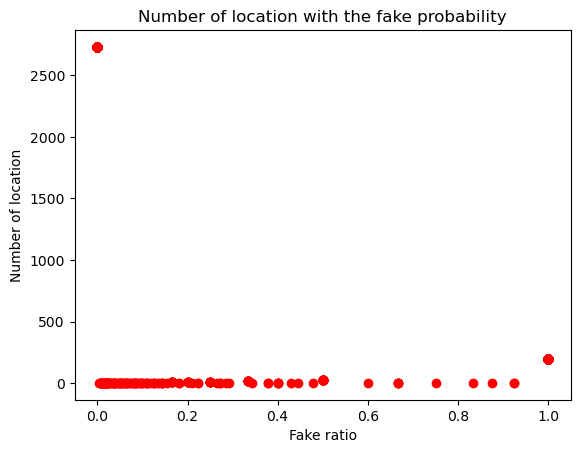

In [14]:
plt.plot(ratio.values,y,'ro')
plt.ylabel('Number of location')
plt.xlabel('Fake ratio')
plt.title("Number of location with the fake probability")

# Naive Bayes

In [15]:
is_fraud = jobs['fraudulent'] == 1
df_try = jobs[is_fraud]
jobs_over=jobs
jobs_over=jobs_over.append([df_try]*18,ignore_index=True)

<AxesSubplot:ylabel='fraudulent'>

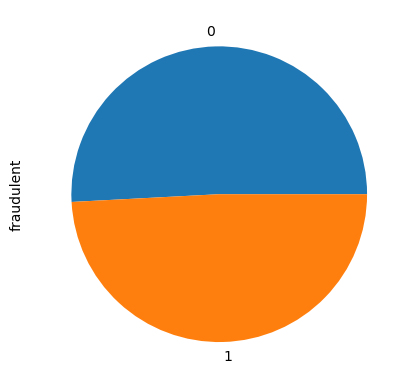

In [16]:
jobs_over.fraudulent.value_counts().plot(kind='pie')

In [17]:
from sklearn import preprocessing
jobs_last = jobs_over.drop(columns = ['job_id','company_profile', 'description', 'benefits', 'requirements','fraudulent'])
jobs_last.head()
X=np.zeros((len(jobs_last),len(jobs_last.columns)))
for j in range(len(jobs_last.columns)):
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers.
    Xoszlop=le.fit_transform(jobs_last[jobs_last.columns[j]])
    X[:,j]=Xoszlop
print(X[0])

[5.811e+03 2.535e+03 7.580e+02 8.740e+02 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 4.000e+00 1.300e+01 1.310e+02 2.200e+01]


In [18]:
y = jobs_over.fraudulent.values
y = y.reshape(-1,1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 0)

In [20]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(class_prior=[jobs_over.fraudulent.value_counts()[0],jobs_over.fraudulent.value_counts()[1]])
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [21]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9521959964146998


In [22]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=y_pred[i]
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

[[1516.   21.]
 [ 139. 1671.]]


# Adat átalakítás numerikus értékekké

In [23]:
jobs_last = jobs_over.drop(columns = ['job_id','department',
                             'salary_range', 'company_profile','description','requirements','benefits','fraudulent'])
jobs_last.head()

,title,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",0,1,0,Other,Internship,NaN,NaN,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",0,1,0,NaN,NaN,NaN,NaN,NaN
3,Account Executive - Washington DC,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [25]:
from sklearn.preprocessing import OneHotEncoder
# Minden oszlopot elkódolok a onehot kódolással
onehot=dict()
for c in jobs_last.columns:
    X=jobs_last[c].array.reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    onehot[c]=enc.fit_transform(X).toarray()

In [27]:
import random
X=[]
rand=[]
for i in range(5000): # Kiválsztok 5000 véletlen sort.
    rand.append(random.randint(0, 33468))

for i in range(5000): # Ezekhez a sorokhoz összefűzöm az oszlopoknak megfelelő 0-1 vektorokat. 
    Xi=[]
    for c in jobs_last.columns:
        Xi=Xi+list(onehot[c][rand[i]])
    X.append(Xi)

In [28]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X=pca.fit_transform(X)
print(pca.get_params())
print(X)

{'copy': True, 'iterated_power': 'auto', 'n_components': 100, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
[[ 1.29841471e+00  3.73485924e-01 -1.97161744e-01 ... -1.21261199e-02
  -3.47511031e-02  9.04423941e-03]
 [-6.91238999e-01  5.13532251e-01  1.41318848e+00 ... -2.87453291e-02
   1.06086353e-02 -6.05345128e-02]
 [-3.45837916e-01  1.55617115e-01  1.47405324e+00 ...  3.56031068e-03
   4.53575073e-02  2.52780225e-02]
 ...
 [-2.18896800e-01  6.49539383e-02  1.21705402e+00 ...  8.68109075e-02
  -4.59968730e-02 -9.85558741e-02]
 [-8.65463555e-01  5.77133382e-01 -4.84635801e-01 ... -1.67204851e-01
  -2.06557240e-01  1.34385014e-02]
 [ 1.87011515e+00 -3.78584947e-03  7.14244935e-02 ...  2.52622424e-02
  -8.61345590e-03  4.40698294e-04]]


In [29]:
# A fraudulent értékek
y=np.zeros(5000)
for i in range(5000):
    y[i]=jobs_over.fraudulent[rand[i]]
y = y.reshape(-1,1)
print(y)

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


# Support Vector Machine

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [33]:
from sklearn import svm
clf = svm.SVC(kernel='poly',max_iter=1000)
clf = clf.fit(X_train, y_train)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=y_pred[i]
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

[[227.  22.]
 [ 17. 234.]]


# Decision Tree

In [36]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=10)
clf = clf.fit(X_train, y_train)

In [37]:
#tree.plot_tree(clf)

In [38]:
y_pred = clf.predict(X_test)

In [39]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=y_pred[i]
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

[[216.  10.]
 [ 28. 246.]]


# Random forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf = clf.fit(X_train, y_train)

In [41]:
y_pred = clf.predict(X_test)

In [42]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=y_pred[i]
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

[[235.   9.]
 [  9. 247.]]


# Eddig van

# Adat átalakítás

Csak a description oszlopot tartom meg.

In [ ]:
jobs_last = jobs.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function','has_company_logo','has_questions'])
jobs_last.head()

In [ ]:
jobs_last.fillna(" ", inplace = True)
jobs_last['word count'] = [len(i.split(' ')) for i in jobs_last['description']]

In [ ]:
jobs_last.head()

Átalakítom a szavak számokká. Minden szó egy sorszámot kap, így minden description egy vektor lesz.

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [ ]:
max_features = 10000
t = Tokenizer(num_words = max_features)
# fit the tokenizer on the documents
t.fit_on_texts(list(jobs_last['description']))

In [ ]:
encoded_docs = t.texts_to_sequences(list(jobs_last['description']))

In [ ]:
sent_length = jobs_last['word count'].max()
embedded_docs=pad_sequences(encoded_docs,padding='pre',maxlen=sent_length)

In [ ]:
print(embedded_docs)

In [ ]:
y = jobs_last.fraudulent.values
y = y.reshape(-1,1)
X = np.array(embedded_docs)

# Egyszerű Döntési fa

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [ ]:
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape )
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=10)
clf = clf.fit(X_train, y_train)

In [ ]:
#tree.plot_tree(clf)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Az előző kézzel.
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
print(acc[1,1]/sum(acc[:,1]))

In [ ]:
depth=np.arange(1,15)
acc1=[]
for j in range(1,15):
    clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=j)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc=np.zeros((2,2))
    for i in range(len(X_test)):
        if y_pred[i]==0 and y_test[i]==0:
            acc[0,0]=acc[0,0]+1
        if y_pred[i]==1 and y_test[i]==0:
            acc[1,0]=acc[1,0]+1
        if y_pred[i]==0 and y_test[i]==1:
            acc[0,1]=acc[0,1]+1
        if y_pred[i]==1 and y_test[i]==1:
            acc[1,1]=acc[1,1]+1
    acc1.append(acc[1,1]/sum(acc[:,1]))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depth,acc1,'ro')
plt.ylabel('fake news ratio')
plt.xlabel('Tree depth')

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='poly',max_iter=10000)
clf = clf.fit(X_train[:600], y_train[:600])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Az előző kézzel.
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
>>> from sklearn.feature_extraction.text import TfidfVectorizer
>>> corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
>>> vectorizer = TfidfVectorizer()
>>> X = vectorizer.fit_transform(corpus)
>>> print(vectorizer.get_feature_names_out())
print(X.toarray())
>>> print(X.shape)
print(type(X))
vectorizer.vocabulary_.get('is')